# **Facial Key Point Detection**

**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Loading Data**

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7' -O KeyFacialPoints.csv

facialpoints_df = pd.read_csv('KeyFacialPoints.csv')

--2021-03-31 09:41:14--  https://docs.google.com/uc?export=download&id=1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.139, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hjqsh9vcrl80mo27nrfkqml1u9frn3kr/1617183675000/17242455652310080862/*/1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7?e=download [following]
--2021-03-31 09:41:16--  https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hjqsh9vcrl80mo27nrfkqml1u9frn3kr/1617183675000/17242455652310080862/*/1mjhp6dyuY5cIt78yX4VqIhBn6322FMD7?e=download
Resolving doc-08-7s-docs.googleusercontent.com (doc-08-7s-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-08-7s-docs.googleusercontent.com (doc-08-7s-d

In [ ]:
facialpoints_df

left_eye_center_x  ...                                              Image
0             66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1             64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2             65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3             65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4             66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...
...                 ...  ...                                                ...
2135          67.180378  ...  191 191 191 190 189 185 184 120 54 34 19 24 31...
2136          65.724490  ...  19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137          68.430866  ...  31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138          64.152180  ...  7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139          66.683755  ...  68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...

[2140 rows x 31 columns]

In [ ]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
facialpoints_df['Image'][1]

'219 215 204 196 204 211 212 200 180 168 178 196 194 196 203 209 199 192 197 201 207 215 199 190 182 180 183 190 190 176 175 175 170 158 162 170 150 133 133 128 121 115 115 114 112 114 113 112 120 127 123 118 112 109 112 110 107 106 104 104 100 98 105 122 135 143 152 135 114 104 81 74 87 107 98 82 84 79 70 69 62 62 79 94 97 100 98 93 100 100 97 96 93 92 88 84 222 219 220 211 207 199 185 178 171 175 196 199 199 200 201 205 202 200 204 206 211 219 204 192 188 185 185 193 189 180 177 178 173 158 159 162 145 133 133 129 122 118 116 115 114 115 115 118 127 132 127 120 116 119 118 114 114 113 110 108 105 104 110 130 140 149 152 128 106 106 91 78 90 107 101 84 90 93 79 75 73 59 58 74 94 102 100 99 97 90 94 96 95 92 88 86 231 224 212 197 191 186 176 170 172 190 201 199 200 203 204 210 215 211 210 213 213 217 210 192 188 188 189 194 189 183 181 183 175 158 158 158 142 132 133 131 125 120 121 120 116 115 116 122 135 137 129 122 121 125 121 119 120 118 117 112 112 109 116 136 149 156 149 126 109 

In [ ]:
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [ ]:
facialpoints_df['Image'][1].shape

(96, 96)

In [ ]:
facialpoints_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [ ]:
facialpoints_df.describe()

left_eye_center_x  ...  mouth_center_bottom_lip_y
count        2140.000000  ...                2140.000000
mean           66.221549  ...                  82.630412
std             2.087683  ...                   4.813557
min            47.835757  ...                  57.232296
25%            65.046300  ...                  79.417480
50%            66.129065  ...                  82.388899
75%            67.332093  ...                  85.697976
max            78.013082  ...                  95.808983

[8 rows x 30 columns]

**Image Visualisation**

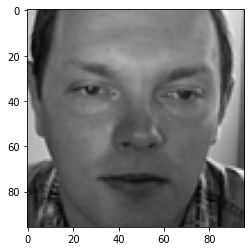

In [ ]:
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray')

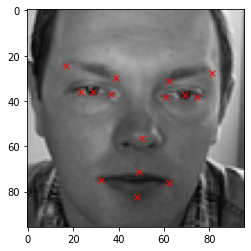

In [ ]:
plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

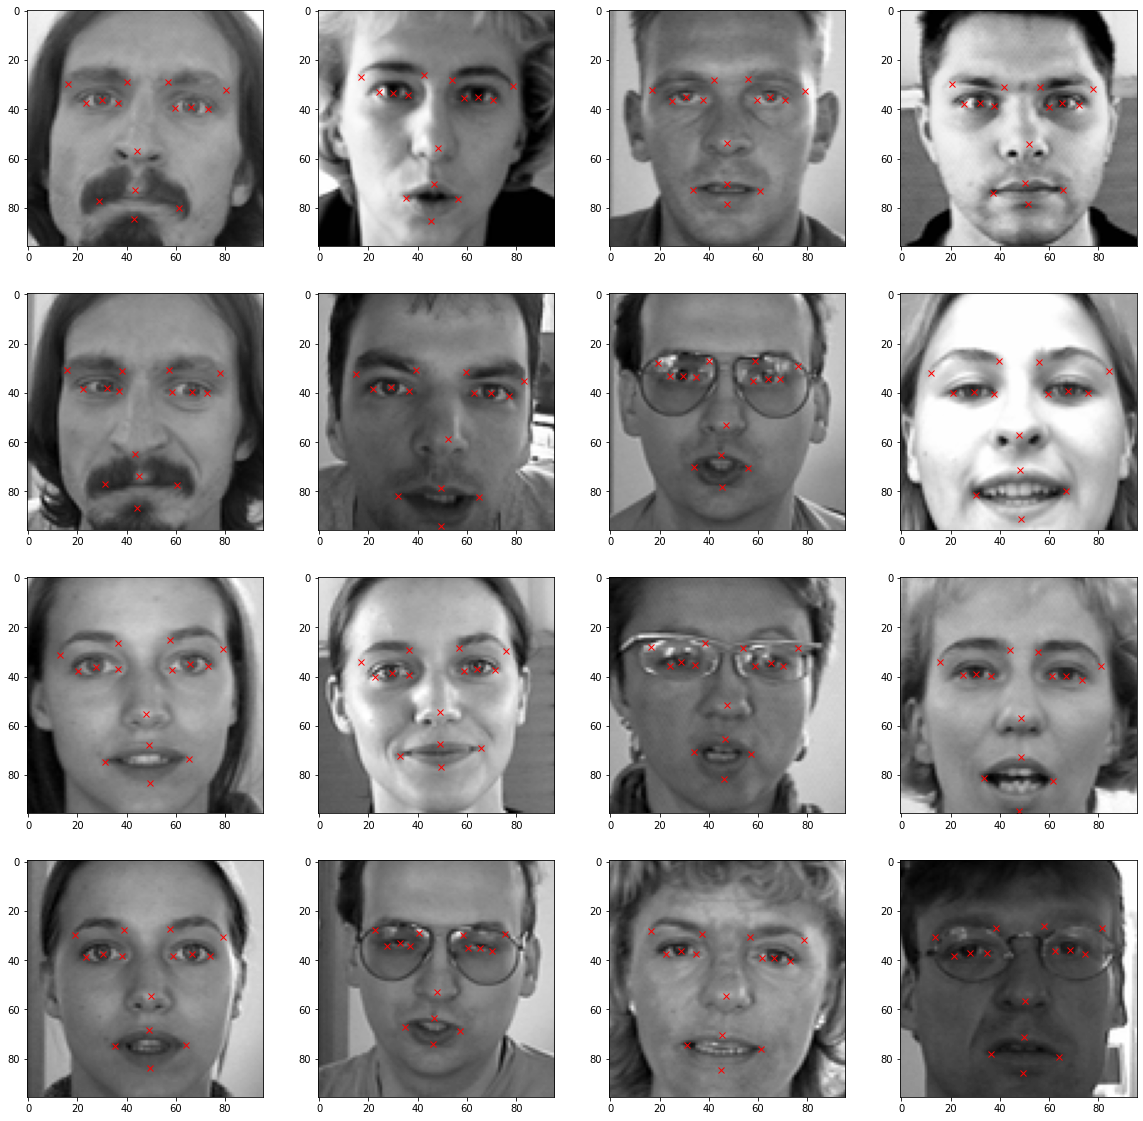

In [ ]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

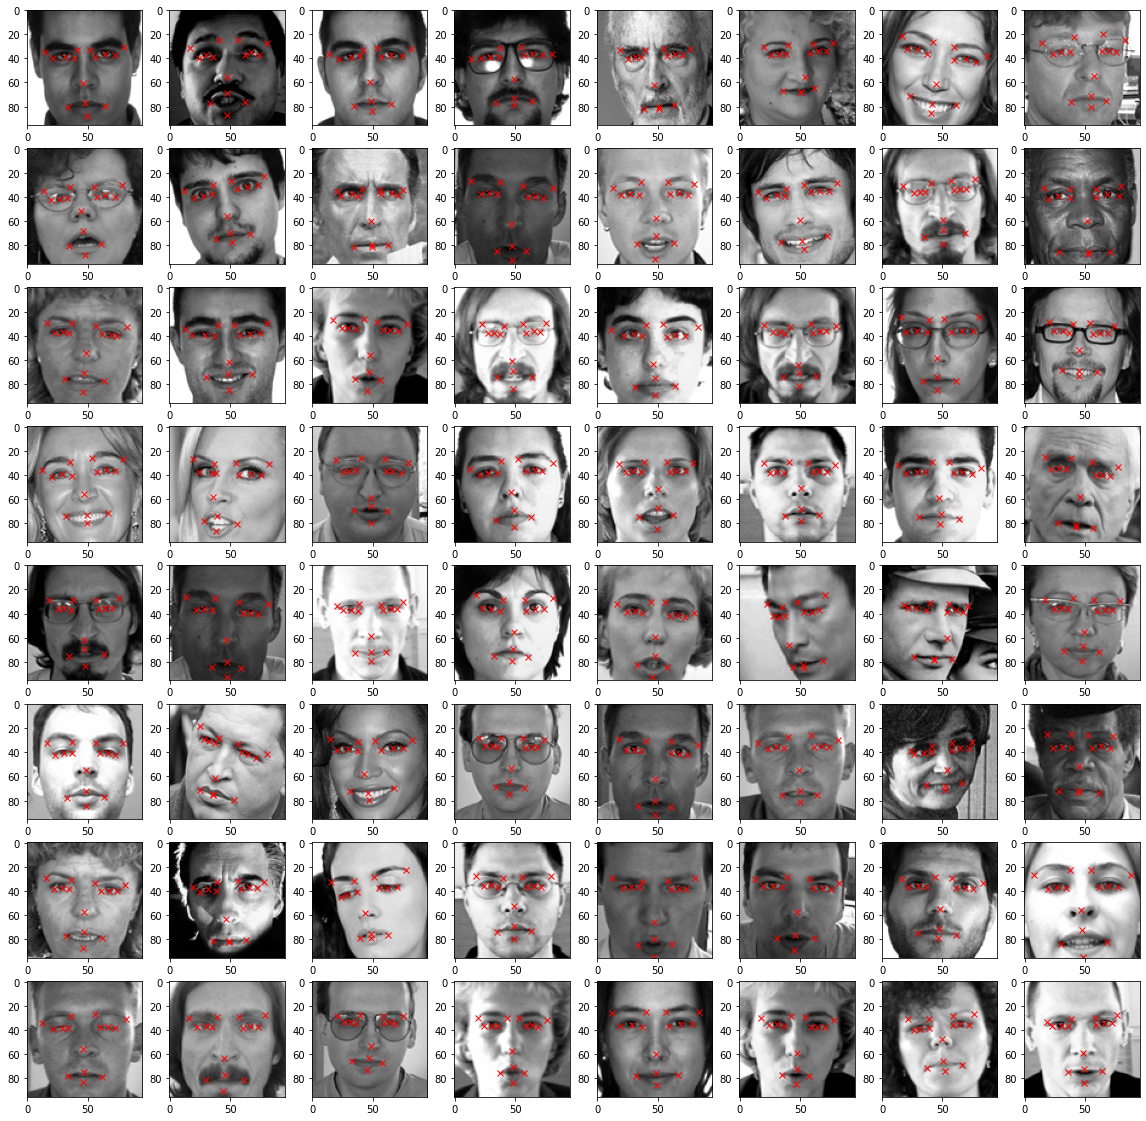

In [ ]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    img = np.random.randint(1, len(facialpoints_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][img], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[img][j-1], facialpoints_df.loc[img][j], 'rx')

**Image Augmentation**

In [ ]:
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [ ]:
columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [ ]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

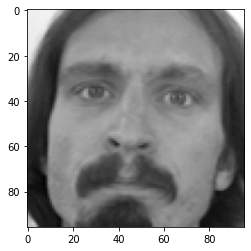

In [ ]:
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [ ]:
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

In [ ]:
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

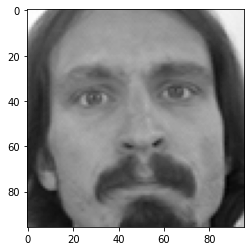

In [ ]:
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

In [ ]:
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

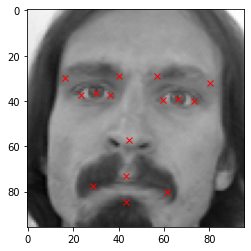

In [ ]:
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

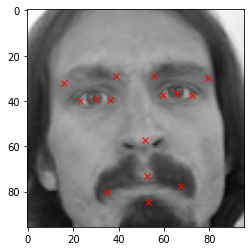

In [ ]:
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [ ]:
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [ ]:
facialpoints_df_augmented.shape

(4280, 31)

In [ ]:
import random

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

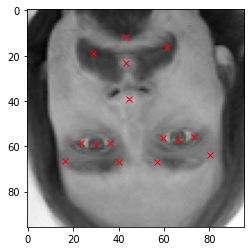

In [ ]:
facialpoints_df_copy = copy.copy(facialpoints_df)

# Flip the image column vertically (note that axis = 0) 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

facialpoints_df['Image'][0]

facialpoints_df_copy['Image'][0]

# Since we are flipping the images vertically, x coordinate values would be the same
# y coordinate values only would need to change, all we have to do is to subtract our initial y-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )
    
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [ ]:
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(8560, 31)

**Normalizing and preparing Training Data**

In [ ]:
img = facialpoints_df_augmented[:, 30]
img = img/255.

X = np.empty((len(img), 96, 96, 1))

for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [ ]:
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
X_train.shape

(7704, 96, 96, 1)

In [ ]:
X_test.shape

(856, 96, 96, 1)

In [ ]:
y_train.shape

(7704, 30)

In [ ]:
y_test.shape

(856, 30)

**Building Deep Learning models**

In [ ]:
def res_block(X, filter, stage):
    
  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  #Layer L+1
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  #Layer L+2
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  #Layer L+3
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 1
  X_copy = X
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

**Compiling and training the model**

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/100
29/29 [==============================] - 158s 5s/step - loss: 852.3975 - accuracy: 0.2665 - val_loss: 1946.3062 - val_accuracy: 0.4145

Epoch 00001: val_loss improved from inf to 1946.30615, saving model to weights.hdf5
Epoch 2/100
29/29 [==============================] - 154s 5s/step - loss: 151.0903 - accuracy: 0.5212 - val_loss: 1484.0857 - val_accuracy: 0.4145

Epoch 00002: val_loss improved from 1946.30615 to 1484.08569, saving model to weights.hdf5
Epoch 3/100
29/29 [==============================] - 160s 6s/step - loss: 99.9707 - accuracy: 0.7313 - val_loss: 1080.6841 - val_accuracy: 0.4145

Epoch 00003: val_loss improved from 1484.08569 to 1080.68408, saving model to weights.hdf5
Epoch 4/100
29/29 [==============================] - 155s 5s/step - loss: 59.6144 - accuracy: 0.7155 - val_loss: 829.7183 - val_accuracy: 0.4145

Epoch 00004: val_loss improved from 1080.68408 to 829.71832, saving model to weights.hdf5
Epoch 5/100
29/29 [==============================] - 15

In [ ]:
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

**Evaluating the performance of the model**

In [ ]:
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [ ]:
model.save('./MyModel_tf',save_format='tf')


# loading the saved model
loaded_model = tf.keras.models.load_model('./MyModel_tf')

# retraining the model
loaded_model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

INFO:tensorflow:Assets written to: ./MyModel_tf/assets
Epoch 1/100
29/29 [==============================] - 161s 5s/step - loss: 210.8837 - accuracy: 0.7052 - val_loss: 85.0993 - val_accuracy: 0.7098

Epoch 00001: val_loss did not improve from 41.35127
Epoch 2/100
29/29 [==============================] - 158s 5s/step - loss: 14.0028 - accuracy: 0.7566 - val_loss: 64.0373 - val_accuracy: 0.7098

Epoch 00002: val_loss did not improve from 41.35127
Epoch 3/100
29/29 [==============================] - 157s 5s/step - loss: 9.8108 - accuracy: 0.7725 - val_loss: 57.4724 - val_accuracy: 0.7098

Epoch 00003: val_loss did not improve from 41.35127
Epoch 4/100
29/29 [==============================] - 158s 5s/step - loss: 8.6375 - accuracy: 0.7779 - val_loss: 48.9031 - val_accuracy: 0.7254

Epoch 00004: val_loss did not improve from 41.35127
Epoch 5/100
29/29 [==============================] - 158s 5s/step - loss: 7.5661 - accuracy: 0.7815 - val_loss: 43.1336 - val_accuracy: 0.7435

Epoch 00005: v

In [ ]:
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

27/27 [==============================] - 5s 165ms/step - loss: 28.7561 - accuracy: 0.7942
Accuracy : 0.7943925261497498


In [ ]:
df_predict = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 5.3634819998959635


In [ ]:
df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

left_eye_center_x  ...  mouth_center_bottom_lip_y
0          64.419510  ...                  83.373764
1          28.543625  ...                  85.456093
2          64.458115  ...                  14.337719
3          63.659969  ...                  17.532011
4          27.876518  ...                  85.655548

[5 rows x 30 columns]

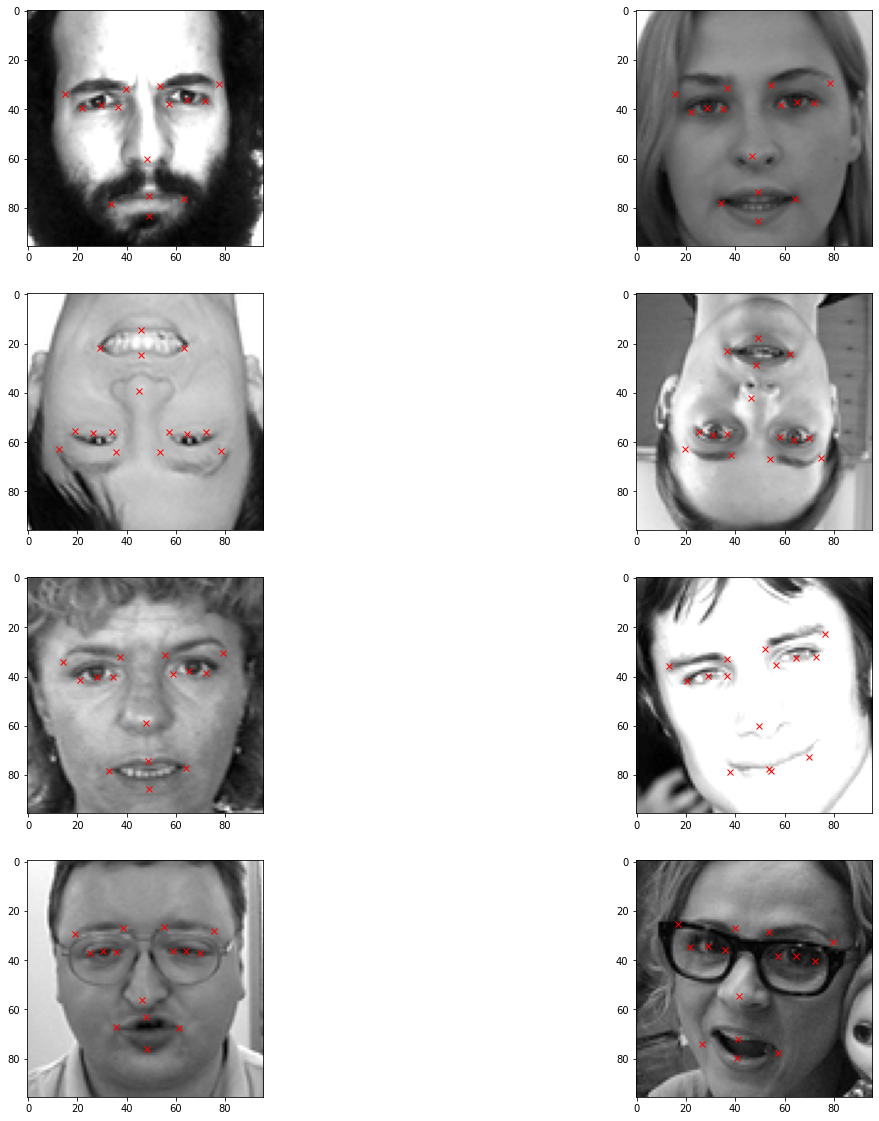

In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

# **Face Expression Recognition**

**Importing Libraries**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install utils
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

In [ ]:
%pwd

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("/content/Project/train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("/content/Project/train/" + expression + "/" +os.listdir("/content/Project/train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

**Sample Images**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1afmZWHWn6sKs2EyygCwfJ4DvPg2EwhnC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1afmZWHWn6sKs2EyygCwfJ4DvPg2EwhnC" -O Project.zip && rm -rf /tmp/cookies.txt
!unzip Project.zip

In [ ]:
plot_example_images(plt).show()

In [ ]:
for expression in os.listdir("/content/Project/train/"):
    print(str(len(os.listdir("/content/Project/train/" + expression))) + " " + expression + " images")

**Generate training and validation batches**

In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/Project/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

val_generator = datagen_train.flow_from_directory("/content/Project/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    shuffle=True)

datagen_test = ImageDataGenerator(horizontal_flip=True)

test_generator = datagen_test.flow_from_directory("/content/Project/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)

**Create CNN Model**

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

**Train and Evaluate model**

In [ ]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Represent Model as JSON String**

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# **Classify radio signals**

**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19nuL1JWqCDerQxfh1jrFtYyQsYP3Oq55' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19nuL1JWqCDerQxfh1jrFtYyQsYP3Oq55" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip dataset.zip

**Load and Preprocess SETI Data**

In [ ]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)

val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [ ]:
train_images.head()

In [ ]:
train_labels.head()

In [ ]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

In [ ]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

**Plot 2D Spectrograms**

In [ ]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

In [ ]:
plt.imshow(np.squeeze(x_train[3]), cmap="gray");

**Create Training and Validation Data Generators**

In [ ]:
?ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

**Creating a CNN Model**

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [ ]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

**Learning Rate Scheduling and Compile the Model**

In [ ]:
?tf.keras.optimizers.schedules.ExponentialDecay

In [ ]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

**Training the model**

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [checkpoint]#, reduce_lr]
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

**Model Evaluation**

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

In [ ]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# **Food classification**

**Loading the Data**

In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
import os
get_data_extract()

4996284416/4996278331 [==============================] - 258s 0us/step
Dataset downloaded and extracted!


In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['images', 'README.txt', 'license_agreement.txt', 'meta']

In [ ]:
os.listdir('food-101/images')

['mussels',
 'pulled_pork_sandwich',
 'beef_tartare',
 'club_sandwich',
 'spaghetti_bolognese',
 'garlic_bread',
 'scallops',
 'pad_thai',
 'waffles',
 'beignets',
 'escargots',
 'cheese_plate',
 'macarons',
 'lobster_bisque',
 'gnocchi',
 'huevos_rancheros',
 'lasagna',
 'onion_rings',
 'risotto',
 'macaroni_and_cheese',
 'pancakes',
 'bibimbap',
 'chocolate_cake',
 'hamburger',
 'omelette',
 'shrimp_and_grits',
 'red_velvet_cake',
 'greek_salad',
 'clam_chowder',
 'peking_duck',
 'foie_gras',
 'spring_rolls',
 'eggs_benedict',
 'gyoza',
 'pho',
 'cheesecake',
 'hummus',
 'paella',
 'donuts',
 'hot_dog',
 'breakfast_burrito',
 'strawberry_shortcake',
 'french_fries',
 'ravioli',
 'churros',
 'caprese_salad',
 'cannoli',
 'panna_cotta',
 'pork_chop',
 'ceviche',
 'samosa',
 'poutine',
 'tacos',
 'fried_rice',
 'apple_pie',
 'baby_back_ribs',
 'crab_cakes',
 'chocolate_mousse',
 'dumplings',
 'falafel',
 'seaweed_salad',
 'oysters',
 'baklava',
 'beef_carpaccio',
 'chicken_curry',
 'tun

In [ ]:
os.listdir('food-101/meta')

['classes.txt',
 'test.txt',
 'train.txt',
 'test.json',
 'labels.txt',
 'train.json']

In [ ]:
train = []
valid = []
test = []

#os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./training'):
  train_class = os.listdir(os.path.join('training',i))
  train.extend(train_class)
  valid_class = os.listdir(os.path.join('validation',i))
  valid.extend(valid_class)
  test_class = os.listdir(os.path.join('evaluation',i))
  test.extend(test_class)

print('Number of train images : {} \nNumber of validation images : {} \nNumber of test images : {}'.format(len(train),len(valid),len(test)))

In [ ]:
#Visualize the images in the dataset

fig, axs = plt.subplots(11,5, figsize=(32,32))
count = 0
for i in os.listdir('./training'):
  # get the list of images in the particualr class
  train_class = os.listdir(os.path.join('training',i))
  #plot 5 images per class
  for j in range(5):
    img = os.path.join('training',i,train_class[j])
    
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()

In [ ]:
#check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./training'):
  train_class = os.listdir(os.path.join('training',i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i,len(train_class)))

In [ ]:
#visualize the number of images in each class in the training dataset

fig = plt.figure(figsize=(10,5))
plt.bar(Class_name, No_images_per_class,color = sns.color_palette("cubehelix",len(Class_name)))
fig.tight_layout()

**Perform Data Augmentation and create Data Generator:**

In [ ]:
#create run-time augmentation on training and test dataset
#For training datagenerator,we add normalization ,shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(
        'training',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'evaluation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

**Building a Deep Learning Model Using Pre-Trained InceptionRESNETV2**

In [ ]:
#load the inception resnetv2 model

basemodel = InceptionResNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [ ]:
#print the model summary
basemodel.summary()

In [ ]:
#Freeze the basemodel weights , so these weights won't change during training
basemodel.trainable = False

In [ ]:
#Add classifiction head to the model

headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = 'global_average_pool')(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu", name = 'dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = 'dense_2')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(11, activation = 'softmax', name = 'dense_3')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

**Compiling and Training the Model**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer= SGD(lr=.01, momentum=.9) , metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

**Fine Tuning the Trained Model**

In [ ]:
basemodel.trainable = True

In [ ]:
model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="weights_fine.hdf5", verbose=1, save_best_only=True)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer= SGD(lr=0.0001, momentum=.9) , metrics= ["accuracy"])
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 10, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer, earlystopping])

In [ ]:
model.load_weights("weights_fine.hdf5")

**Evaluating the performance of the Trained Model**

In [ ]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

In [ ]:
labels = {0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3:'Egg', 4: 'Fried food', 5:'Meat',6:'Noodles-Pasta',7:'Rice', 8:'Seafood',9:'Soup',10: 'Vegetable-Fruit'}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir('./evaluation'):
  for item in os.listdir(os.path.join('./evaluation',i)):

    img= PIL.Image.open(os.path.join('./evaluation',i,item))

    img = img.resize((256,256))

    image.append(img)

    img = np.asarray(img, dtype= np.float32)

    img = img / 255

    img = img.reshape(-1,256,256,3)

    predict = model.predict(img)

    predict = np.argmax(predict)

    prediction.append(labels[predict])

    original.append(i)

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

In [ ]:
plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

**Visualising Activation Maps through GRAD-CAM**

In [ ]:
def grad_cam(img):

  img = np.asarray(img, dtype= np.float32)

  img = img.reshape(-1,256,256,3)
  img_scaled = img / 255

  classification_layers = ["global_average_pool","dense_1","dense_2","dense_3"]

  final_conv = model.get_layer("conv_7b")

  final_conv_model = keras.Model(model.inputs, final_conv.output)

  classification_input = keras.Input(shape=final_conv.output.shape[1:])

  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)

  with tf.GradientTape() as tape:
      
      final_conv_output = final_conv_model(img_scaled)

      tape.watch(final_conv_output)
      
      prediction = classification_model(final_conv_output)
      predicted_class = tf.argmax(prediction[0])
      predicted_class_value = prediction[:, predicted_class]

  gradient = tape.gradient(predicted_class_value, final_conv_output)

  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  #convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap o top of the original image
  final_img = heatmap * 0.8 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

In [ ]:
import random
fig, axs = plt.subplots(11,3, figsize=(32,32))
count = 0
for _ in range(11):
  i = random.randint(0,len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Prediction -" + prediction[i]) 
  axs[count][1].matshow(heatmap)
  axs[count][2].title.set_text("Heatmap") 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()

# **Traffic Sign Classification**

**Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import random

**Loading the Data**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tQ2HkQdxCUpAo4twbqN6mu7FYD7Ry5tq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tQ2HkQdxCUpAo4twbqN6mu7FYD7Ry5tq" -O train.p && rm -rf /tmp/cookies.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zJxB1YzBYuImaHBSxWGN-ZXPDRYN_CTX' -O valid.p
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jZhZpEZkYFaaPPAwfd1cB8e-FK0aoeC0' -O test.p

--2021-03-31 18:34:45--  https://docs.google.com/uc?export=download&confirm=l0ek&id=1tQ2HkQdxCUpAo4twbqN6mu7FYD7Ry5tq
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.101, 74.125.142.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-94-docs.googleusercontent.com/docs/securesc/80lgvsp114pd7q8jj3k3nrqcv45dgs25/9l3gu16atqit38jc1f4u6on8o04uh4vn/1617215625000/17242455652310080862/03208712808601464492Z/1tQ2HkQdxCUpAo4twbqN6mu7FYD7Ry5tq?e=download [following]
--2021-03-31 18:34:45--  https://doc-0s-94-docs.googleusercontent.com/docs/securesc/80lgvsp114pd7q8jj3k3nrqcv45dgs25/9l3gu16atqit38jc1f4u6on8o04uh4vn/1617215625000/17242455652310080862/03208712808601464492Z/1tQ2HkQdxCUpAo4twbqN6mu7FYD7Ry5tq?e=download
Resolving doc-0s-94-docs.googleusercontent.com (doc-0s-94-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting

In [ ]:
with open("/content/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("/content/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("/content/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [ ]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
X_train.shape

(34799, 32, 32, 3)

In [ ]:
y_train.shape

(34799,)

35

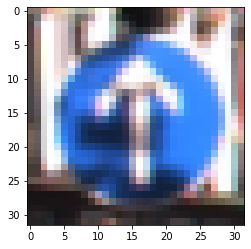

In [ ]:
i = np.random.randint(1, len(X_train))
plt.imshow(X_train[i])
y_train[i]

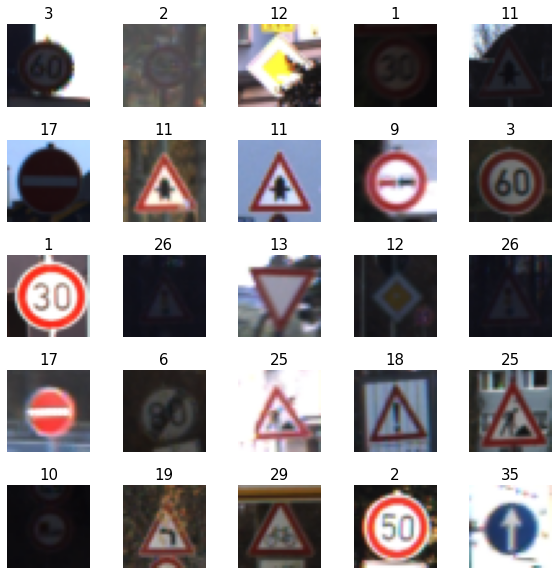

In [ ]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow( X_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

        

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)
X_validation_gray = np.sum(X_validation/3, axis = 3, keepdims = True)

In [ ]:
X_train_gray.shape

(34799, 32, 32, 1)

In [ ]:
X_test_gray.shape

(12630, 32, 32, 1)

In [ ]:
X_validation_gray.shape

(4410, 32, 32, 1)

In [ ]:
X_train_gray_norm = (X_train_gray - 128)/128
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray - 128)/128

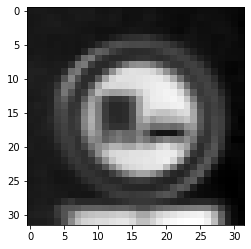

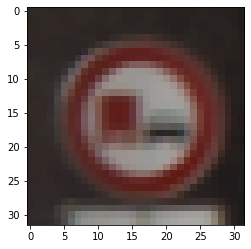

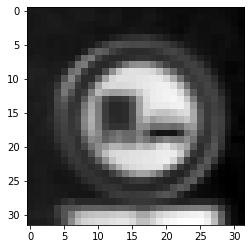

In [ ]:
i = random.randint(1, len(X_train_gray))
plt.imshow(X_train_gray[i].squeeze(), cmap = 'gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')

**Before**

In [ ]:
from tensorflow.keras import datasets, layers, models

CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1)))
CNN.add(layers.AveragePooling2D())

#CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5,5), activation = 'relu'))
CNN.add(layers.AveragePooling2D())

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))

CNN.add(layers.Dense(84, activation = 'relu'))

CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)                1

In [ ]:
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = CNN.fit(X_train_gray_norm,
                 y_train, 
                 batch_size = 500,
                 epochs = 5,
                 verbose = 1,
                 validation_data = (X_validation_gray_norm, y_validation))

Epoch 1/5
70/70 [==============================] - 20s 281ms/step - loss: 3.3864 - accuracy: 0.1260 - val_loss: 2.3779 - val_accuracy: 0.3601
Epoch 2/5
70/70 [==============================] - 15s 215ms/step - loss: 1.7700 - accuracy: 0.5026 - val_loss: 1.3480 - val_accuracy: 0.6204
Epoch 3/5
70/70 [==============================] - 15s 209ms/step - loss: 0.9908 - accuracy: 0.7112 - val_loss: 1.0089 - val_accuracy: 0.7109
Epoch 4/5
70/70 [==============================] - 15s 208ms/step - loss: 0.7026 - accuracy: 0.8039 - val_loss: 0.9098 - val_accuracy: 0.7370
Epoch 5/5
70/70 [==============================] - 15s 208ms/step - loss: 0.5552 - accuracy: 0.8470 - val_loss: 0.7203 - val_accuracy: 0.7891


In [ ]:
score = CNN.evaluate(X_test_gray_norm, y_test)
print('Test Accuracy: {}'.format(score[1]))

395/395 [==============================] - 3s 8ms/step - loss: 0.9428 - accuracy: 0.7804
Test Accuracy: 0.7803642153739929


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

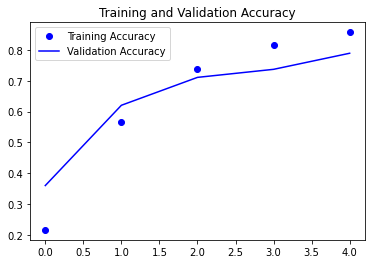

In [ ]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

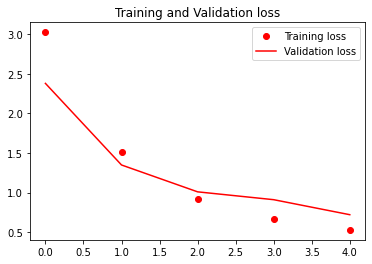

In [ ]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [ ]:
predicted_classes = CNN.predict_classes(X_test_gray_norm)
y_true = y_test

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


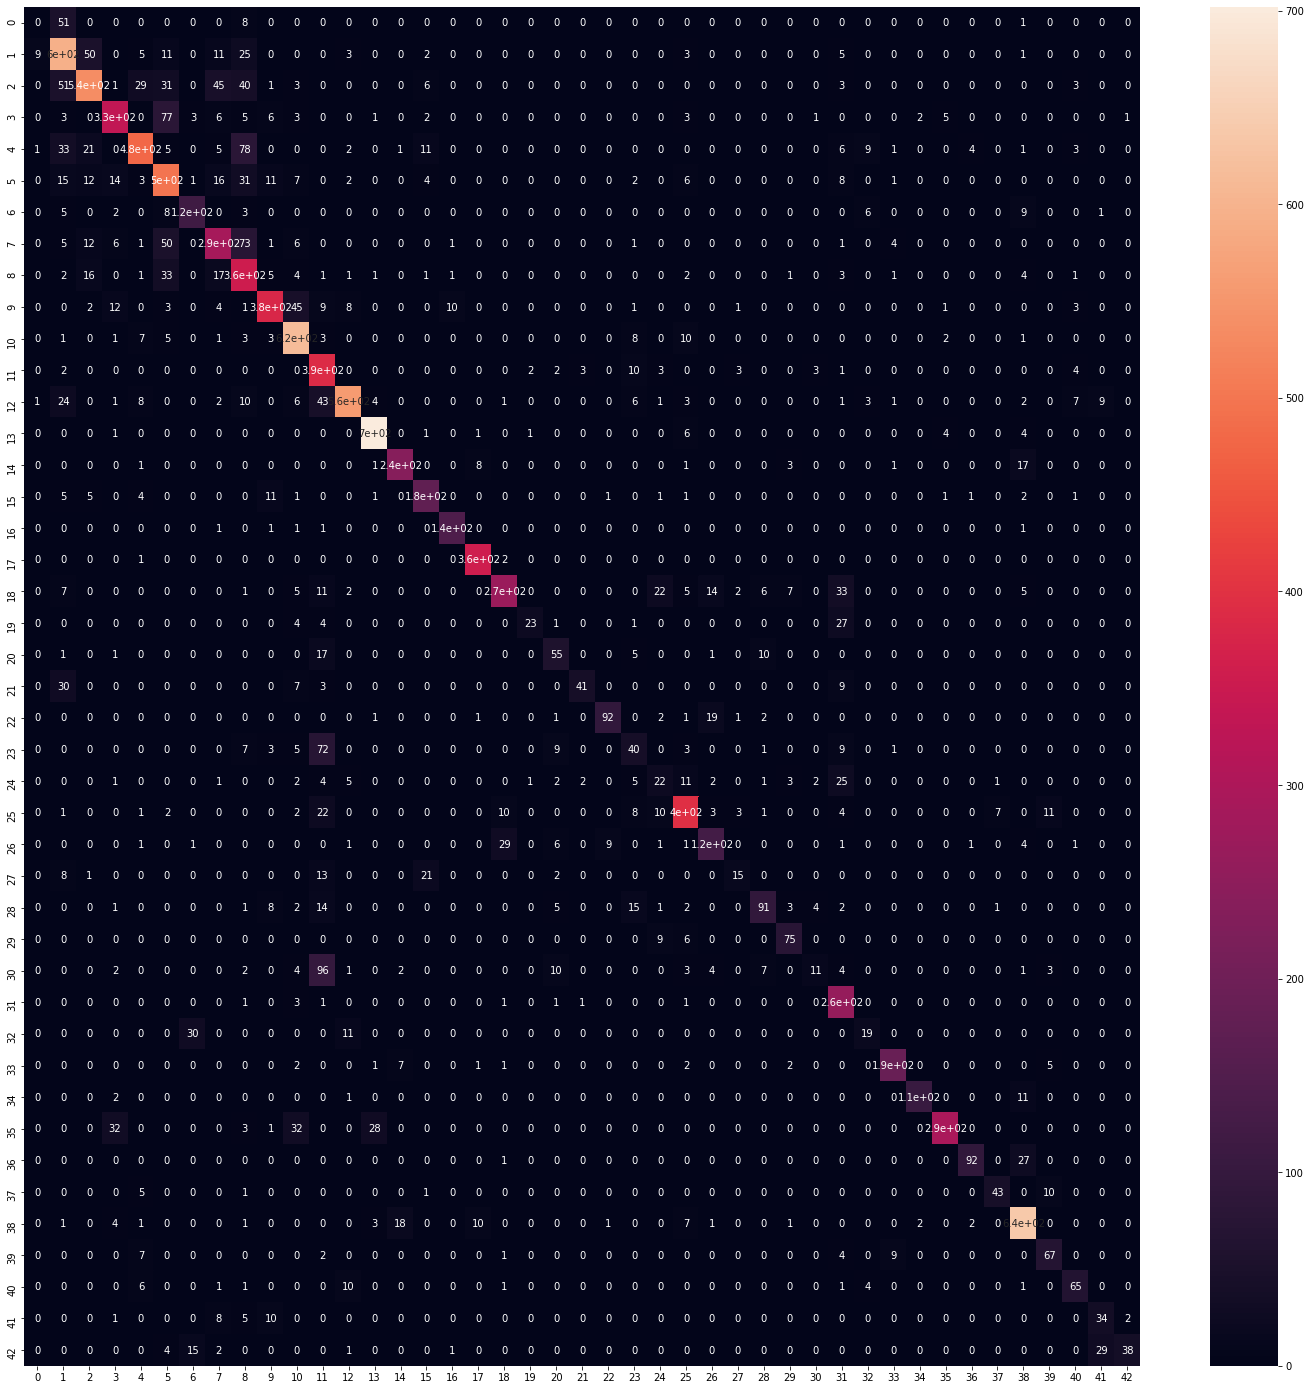

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

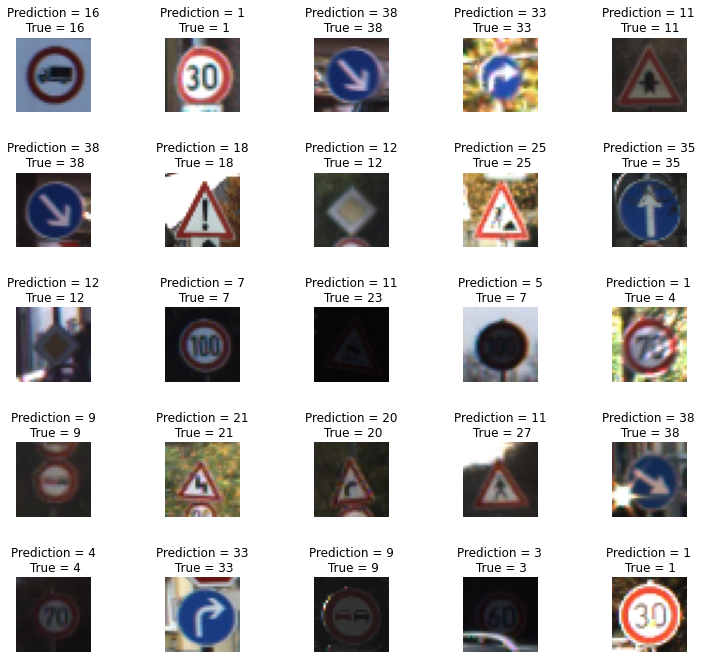

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)    

**After**

In [ ]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
import cv2

def preprocessing(img):
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img/255

  return img

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_validation = X_validation.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train_gray_norm)

In [ ]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 43)
y_validation = to_categorical(y_validation, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten
from keras import optimizers

model = models.Sequential()

model.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(16, (5,5), activation = 'relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(120, activation = 'relu'))

model.add(layers.Dense(84, activation = 'relu'))

model.add(layers.Dense(43, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [ ]:
history = model.fit(datagen.flow(X_train, y_train , batch_size=15),
                      steps_per_epoch= 2000, #len(X_train)//50
                      epochs=30,
                      validation_data=(X_validation, y_validation), shuffle = 1)

Epoch 1/30
2000/2000 [==============================] - 33s 16ms/step - loss: 2.9278 - accuracy: 0.2005 - val_loss: 1.1075 - val_accuracy: 0.6401
Epoch 2/30
2000/2000 [==============================] - 32s 16ms/step - loss: 1.2299 - accuracy: 0.6143 - val_loss: 0.5909 - val_accuracy: 0.8009
Epoch 3/30
2000/2000 [==============================] - 32s 16ms/step - loss: 0.8291 - accuracy: 0.7364 - val_loss: 0.4827 - val_accuracy: 0.8442
Epoch 4/30
2000/2000 [==============================] - 32s 16ms/step - loss: 0.6558 - accuracy: 0.7895 - val_loss: 0.4039 - val_accuracy: 0.8619
Epoch 5/30
2000/2000 [==============================] - 32s 16ms/step - loss: 0.5476 - accuracy: 0.8282 - val_loss: 0.3364 - val_accuracy: 0.8866
Epoch 6/30
2000/2000 [==============================] - 34s 17ms/step - loss: 0.4680 - accuracy: 0.8539 - val_loss: 0.2981 - val_accuracy: 0.9052
Epoch 7/30
2000/2000 [==============================] - 33s 16ms/step - loss: 0.4015 - accuracy: 0.8704 - val_loss: 0.3007 -

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

395/395 [==============================] - 4s 9ms/step - loss: 0.3371 - accuracy: 0.9279
Test Accuracy: 0.9278701543807983
